# Notes

**Focus on**:
- Quality of data
- Log your data and calls when using data scraping
- Creativity
- Visualization (explanatory figures), simple is better
- Be critical of your data collection and generating process
    - Bias
    - Missing data
        - Ignore
        - Collect new data
        - Remove or replace missing data
    - Internal and external validity
    - Data collection type (random, survey, big data, other)
- Less focus on the analytical section and more on the collection and presentation

### Reflect on the ethical aspect
- Do you respect privacy? 
- Can single individuals be identified? 
- What are the potential consequences?
- Are there ethical considerations?
    - With respect to individuals? 
    - With respectto firms or organizations?
- Consider the GDPR:
    - Is it anonymous? 
    - Personal data or statistics?
    - Any change of re-identification?

### Logging

- Log your calls, use it to determine success ratio
    - Where did the call fail? Rewrite code.
    - Don't be greedy. time.sleep(0.5) between each call.
- Visualize the log (lecture 10)

We start by importing our data source to Python. The file *tweets.json* is created from [the Trump twitter archive](http://www.trumptwitterarchive.com/archive). We have selected all tweets from the 20th of January 2017 (assumed office) to 21st of August 2019.

**DOCSTRING**

Below we provide our docstring to the data project.
We import the relevant packages, some of which will require installation through either *pip* or *conda*. 

In [6]:
'''
DOCSTRING:

This project analyzes Donald J. Trump's twitter data and presents a visual analysis of key elements.
It makes use of several packages, some of which should be installed via either pip or conda.
Executing the code cells will save files to the relative path of this Jupyter Notebook. 

'''

# Importing packages
import pandas as pd
import scraping_class, time, json
import numpy as np
from os import path
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import matplotlib.pyplot as plt
from bs4 import BeautifulSoup
from IPython.display import display, HTML
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from afinn import Afinn
from fredapi import Fred
from tqdm import tqdm
% matplotlib inline


UsageError: Line magic function `%` not found.


We set up our connector to the relevant data source and log our connections in a file called *my_log*. 

We later use the log file to visualize our data connection attempts.

In [7]:
logfile = 'my_log'## name your log file.
connector = scraping_class.Connector(logfile)
data = []
# Fetching data
for i in range(2015,2020):
    url = 'http://www.trumptwitterarchive.com/data/realdonaldtrump/'+str(i)+'.json'
    r, call_id = connector.get(url, 'Tweets')
    json_file = r.json() 
    data += json_file[::-1] # invert list
    time.sleep(0.5) # set sleep timer to prevent unintentional DOS attacks

In [8]:
# Creating and manipulating dataframes
# Main dataframe
df = pd.DataFrame(data)
date = [i[2]+i[1]+i[-1]+'-'+i[3] for i in df['created_at'].str.split(' ')] # slice date
df['datetime'] = date
df['datetime'] = pd.to_datetime(df['datetime'], format='%d%b%Y-%H:%M:%S') # format datetime 
#df = df[(df['datetime'] > '2017-01-20')] # filter by relevant date
df = df.query("is_retweet == False") # drop retweets
df = df.reset_index(drop=True).sort_values(by=['datetime']) # set index to date
df.index = df['datetime']

In [9]:
# Define sentiment analyzer score
def sentiment_analyzer_scores(sentence):
    analyser = SentimentIntensityAnalyzer()
    score = analyser.polarity_scores(sentence)
     #print("{:-<40} {}".format(sentence, str(score)))
    return score

def afinn_sentiment_analyzer_scores(sentence):
    afinn = Afinn(language='en')
    score = afinn.score(sentence)
    return score

# Add sentiment to dataframe
df['vader'] = [sentiment_analyzer_scores(tweet)['compound'] for tweet in df['text']]
#df['afinn'] = [afinn_sentiment_analyzer_scores(tweet) for tweet in df['text']]
display(df.head())



,created_at,favorite_count,id_str,in_reply_to_user_id_str,is_retweet,retweet_count,source,text,datetime,vader
datetime,,,,,,,,,,
2015-01-01 00:00:26,Thu Jan 01 00:00:26 +0000 2015,33,550441381253382144,None,False,12,Twitter for Android,"""@JaayZen: @realDonaldTrump Thanks Donald. Now...",2015-01-01 00:00:26,0.7494
2015-01-01 00:02:37,Thu Jan 01 00:02:37 +0000 2015,28,550441927964106753,None,False,9,Twitter for Android,"""@teamconquerca: First time in the""Trump Inter...",2015-01-01 00:02:37,0.8711
2015-01-01 00:06:40,Thu Jan 01 00:06:40 +0000 2015,36,550442948375347200,None,False,15,Twitter for Android,"""@AngelaTN777: @gochico @realDonaldTrump: He S...",2015-01-01 00:06:40,0.4738
2015-01-01 00:09:01,Thu Jan 01 00:09:01 +0000 2015,18,550443540111962113,None,False,11,Twitter for Android,"""@JaayZen: @grandmiapens He has all the ingred...",2015-01-01 00:09:01,0.0000
2015-01-01 00:09:47,Thu Jan 01 00:09:47 +0000 2015,17,550443735054839808,None,False,7,Twitter for Android,"""@MarcAardvark: @realDonaldTrump @ronmeier123 ...",2015-01-01 00:09:47,0.6369


In [6]:
afinn_sentiment_analyzer_scores('I do love ice cream')
sentiment_analyzer_scores('I do love ice cream')

{'neg': 0.0, 'neu': 0.417, 'pos': 0.583, 'compound': 0.6369}

In [8]:
print('Vader sentiment',round(df['vader'].mean(),3))#, 'AFINN sentiment (scaled)', round(df['afinn'].mean()*0.2,3))

Vader sentiment 0.216


In [9]:
print('Since', df.index[0], 'Mr. Trump has made', len(df), 'tweets')

keywords = ['tariff','trade war','trade'] #List of keywords in lowercase

results = {} #Dictionary to store results
for key in keywords:
    print('Sum of tweets containing', key, ':', sum(df['text'].str.contains('(?i)'+str(key))))
    results[key]=sum(df['text'].str.contains('(?i)'+str(key))) #Saving the sum of tweets (ignoring case) containing the key

result_count = {} # empty dictionary to store results
for key in keywords:
    count_=0 #resetting the counter
    for i in range(len(df['text'])): # Looping through all the rows of tweets
        if key in df['text'][i].lower(): # Checking for the key in  the i'th tweet (in lowercase)
            count_ += df['text'][i].lower().count(key) # given the key is found we count the number of times it occurs
        result_count[key]=count_ # Store the count for a given key in the dictionary

print(result_count)      

Since 2015-01-01 00:00:26 Mr. Trump has made 19602 tweets
Sum of tweets containing tariff : 154
Sum of tweets containing trade war : 9
Sum of tweets containing trade : 328
{'tariff': 206, 'trade war': 9, 'trade': 381}


In [15]:
#print(df['text'].resample('M').count())
#print(df['text'].resample('M').count().sum())

# search for keywords while ignoring word case (upper/lower)
df['keyword'] = df['text'].str.contains('(?i)|'.join(keywords)) 
df_filter = df.query("keyword == True") # filter to contain keywords

# Creating figure
ax = plt.gca()
ax = df['text'].resample('M').count().plot(figsize = (10,5), rot = 45, legend=True)
ax1 = plt.gca()
ax1 = df_filter['text'].resample('M').count().plot(figsize = (10,5), rot = 45, secondary_y=True, legend=True)
# Formatting
ax.xaxis.label.set_visible(False) # remove axis label
ax.spines['right'].set_visible(False) # remove right spine
ax.spines['top'].set_visible(False) # remove top spine
ax1.spines['top'].set_visible(False) # remove top spine
ax.xaxis.set_ticks_position('none') # remove ticks from axis
plt.tight_layout() # prevents cutting off labels
plt.savefig('monthlytweets.png')
plt.show()



NameError: name 'keywords' is not defined

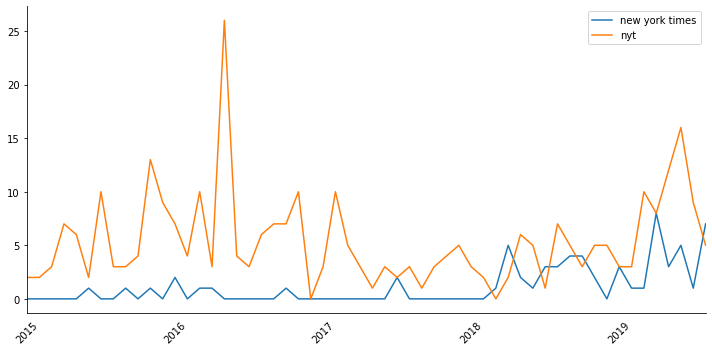

In [16]:
results_time = {}
keywords = ['new york times','nyt']
ax = plt.gca()

# Creating figure
for key in keywords:
    results_time[key] = df['text'].str.contains('(?i)'+str(key)).resample('M').sum()
    ax = df['text'].str.contains('(?i)'+str(key)).resample('M').sum().plot(label=key,
        ax=ax, figsize = (10,5), rot = 45)

# Formatting
ax.xaxis.label.set_visible(False) # remove axis label
ax.spines['right'].set_visible(False) # remove right spine
ax.spines['top'].set_visible(False) # remove top spine
ax.xaxis.set_ticks_position('none') # remove ticks from axis
plt.tight_layout() # prevents cutting off labels
plt.legend()      
plt.savefig('keywords.png')
plt.show()

In [17]:
#WORDCLOUD



# function to get custom color for wordcloud
def custom_color(word=None, font_size=None, position=None, orientation=None, font_path=None, random_state=None):
    h = 30 # int(360.0 * 45.0 / 255.0)
    s = int(100.0 * 255.0 / 255.0)
    l = int(100.0 * float(random_state.randint(100, 160)) / 255.0)

    return "hsl({}, {}%, {}%)".format(h, s, l)
 
# picture used as shape
trump_mask = np.array(Image.open("trump_mask.jpg")) # read image
trump_mask_T = np.array(Image.open("trump_mask.jpg").transpose(Image.FLIP_LEFT_RIGHT)) # read image transposed

# wordcloud for df_filter
text = " ".join(tweet for tweet in df_filter['text'][df_filter['text'].str.contains(r'^(?:(?!https|co|amp).)*$')])
# Create and generate a word cloud image:
wordcloud = WordCloud(max_font_size=50, max_words=100, background_color="white",mask=trump_mask_T, 
                      contour_color ='black',color_func=custom_color).generate(text)
# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

wordcloud.to_file("wordcloud.png") # save file

NameError: name 'df_filter' is not defined

In [ ]:
# wordcloud for df
text = " ".join(tweet for tweet in df['text'][df['text'].str.contains(r'^(?:(?!https|co|amp).)*$')])

# Create and generate a word cloud image:
wordcloud = WordCloud(max_font_size=50, max_words=100, background_color="white",mask=trump_mask, 
                      contour_color ='black',color_func=custom_color).generate(text)

# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

wordcloud.to_file("wordcloud_all.png") # save file

In [18]:
# Define functions to display multiple tables
def multi_table(table_list):
    ''' Acceps a list of IpyTable objects and returns a table which contains each IpyTable in a cell
    '''
    return HTML(
        '<table><tr style="background-color:white;">' + 
        ''.join(['<td>' + table._repr_html_() + '</td>' for table in table_list]) +
        '</tr></table>'
    )
# Fetching trade balance data
url = 'https://www.census.gov/foreign-trade/balance/c5700.html'
r, call_id = connector.get(url,'trade_balance') # connecting and saving connection to log file
dfs = pd.read_html(url) # read the tables
multi_table(dfs[0:4])  # display

,Month,Exports,Imports,Balance
0,January 2019,7134.3,41603.8,-34469.5
1,February 2019,8433.6,33194.4,-24760.8
2,March 2019,10426.5,31175.7,-20749.1
3,April 2019,7896.3,34798.9,-26902.6
4,May 2019,9074.5,39269.1,-30194.6
5,June 2019,9034.7,39002.3,-29967.6
6,TOTAL 2019,52000.0,219044.3,-167044.3
,Month,Exports,Imports,Balance
0,January 2018,9902.6,45765.6,-35863.1
1,February 2018,9759.9,39020.6,-29260.7


In [19]:
# display latex code
for i in range(4):
    print(dfs[i].to_latex(index=False))

\begin{tabular}{lrrr}
\toprule
         Month &  Exports &   Imports &   Balance \\
\midrule
  January 2019 &   7134.3 &   41603.8 &  -34469.5 \\
 February 2019 &   8433.6 &   33194.4 &  -24760.8 \\
    March 2019 &  10426.5 &   31175.7 &  -20749.1 \\
    April 2019 &   7896.3 &   34798.9 &  -26902.6 \\
      May 2019 &   9074.5 &   39269.1 &  -30194.6 \\
     June 2019 &   9034.7 &   39002.3 &  -29967.6 \\
    TOTAL 2019 &  52000.0 &  219044.3 & -167044.3 \\
\bottomrule
\end{tabular}

\begin{tabular}{lrrr}
\toprule
          Month &   Exports &   Imports &   Balance \\
\midrule
   January 2018 &    9902.6 &   45765.6 &  -35863.1 \\
  February 2018 &    9759.9 &   39020.6 &  -29260.7 \\
     March 2018 &   12652.1 &   38327.6 &  -25675.5 \\
     April 2018 &   10503.8 &   38303.9 &  -27800.1 \\
       May 2018 &   10428.2 &   43965.7 &  -33537.5 \\
      June 2018 &   10860.1 &   44612.1 &  -33752.0 \\
      July 2018 &   10134.6 &   47120.6 &  -36986.0 \\
    August 2018 &    9285.9 &

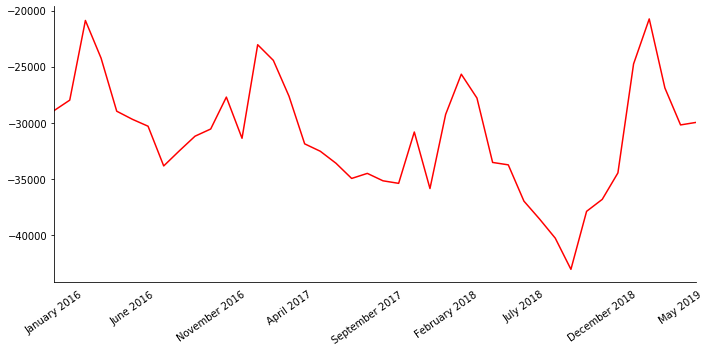

In [20]:
df_trade = pd.concat([dfs[i][:-1] for i in range(4)][::-1]) # removing "total" and concatenating data frames

# Plotting figure
ax = plt.gca()
df_trade.plot(kind='line',x='Month',y='Balance', color='red', ax=ax, figsize = (10,5), rot = 35, legend=False)
ax.xaxis.label.set_visible(False) # remove axis label
ax.spines['right'].set_visible(False) # remove right spine
ax.spines['top'].set_visible(False) # remove top spine
ax.xaxis.set_ticks_position('none') # remove ticks from axis
plt.tight_layout() # prevents cutting off labels
plt.savefig('tradebalance.png')
plt.show()

KeyError: 'afinn'

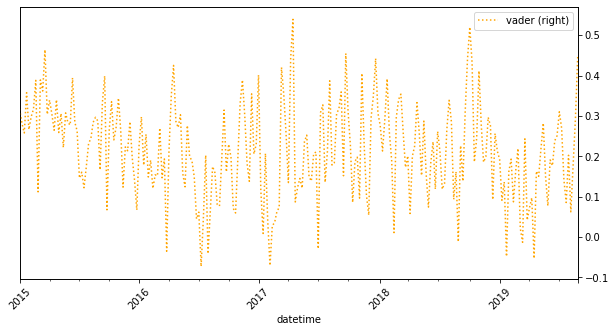

In [21]:
ax = plt.gca()
ax1 = plt.gca()
df['vader'].resample('W').mean().plot(figsize = (10,5), rot = 45, secondary_y=True, legend=True, ax=ax, linestyle=':',color='orange')
df['afinn'].resample('W').mean().plot(figsize = (10,5), rot = 45, secondary_y=False, legend=True, linestyle=':',color='blue')
#ax1 = df_djia.plot(ax = ax1, legend=False)
ax.xaxis.label.set_visible(False) # remove axis label
ax.spines['right'].set_visible(False) # remove right spine
ax.spines['top'].set_visible(False) # remove top spine
ax1.spines['top'].set_visible(False) # remove top spine
ax.xaxis.set_ticks_position('none') # remove ticks from axis
plt.tight_layout() # prevents cutting off labels
plt.savefig('AFINNVADER.png')
plt.show()

In [ ]:
# Import data from the FRED database using the fredapi
fred = Fred(api_key='6d24e44a9ba97a55ef9b9cea11a5a9b2') # connecting using our FRED api key given by FRED.
data = fred.get_series('VXDCLS')#  CBOE DJIA Volatility Index (VXDCLS)

In [ ]:
# COMPARE VIX AND SENTIMENT
df_vix = pd.DataFrame(data)
df_vix.index = pd.to_datetime(df_vix.index)
start_date = '01/01/2015'
series = (df_vix.index >= start_date)
df_vix = df_vix.loc[series]
df_vix.columns = ['VXDCLS']
ax = plt.gca()
ax1 = plt.gca()
df['vader'].resample('W').mean().plot(figsize = (10,5), rot = 45, secondary_y=True, legend=True, ax=ax, linestyle=':',color='orange')
ax1 = df_vix.plot(ax = ax1, legend=True)
ax.xaxis.label.set_visible(False) # remove axis label
ax.spines['right'].set_visible(False) # remove right spine
ax.spines['top'].set_visible(False) # remove top spine
ax1.spines['top'].set_visible(False) # remove top spine
ax.xaxis.set_ticks_position('none') # remove ticks from axis
plt.tight_layout() # prevents cutting off labels
plt.savefig('VXDCLS.png')
plt.show()





In [ ]:
data = fred.get_series('DJIA')# Dow Jones Industrial Average (DJIA)
# COMPARE DJI AND SENTIMENT
df_djia = pd.DataFrame(data)
df_djia.index = pd.to_datetime(df_djia.index)
start_date = '01/01/2015'
series = (df_djia.index >= start_date)
df_djia = df_djia.loc[series]
df_djia.columns = ['DJIA']
ax = plt.gca()
ax1 = plt.gca()
df['vader'].resample('W').mean().plot(figsize = (10,5), rot = 45, secondary_y=True, legend=True, ax=ax, linestyle=':',color='orange')
ax1 = df_djia.plot(ax = ax1, legend=True)

ax.xaxis.label.set_visible(False) # remove axis label
ax.spines['right'].set_visible(False) # remove right spine
ax.spines['top'].set_visible(False) # remove top spine
ax1.spines['top'].set_visible(False) # remove top spine
ax.xaxis.set_ticks_position('none') # remove ticks from axis
plt.tight_layout() # prevents cutting off labels
plt.savefig('DJIA.png')
plt.show()

In [ ]:
data = fred.get_series('DTWEXM')#Trade Weighted U.S. Dollar Index: Major Currencies, Goods (DTWEXM)
# COMPARE Major currencies basket AND SENTIMENT
df_curr = pd.DataFrame(data)
df_curr.index = pd.to_datetime(df_curr.index)
start_date = '01/01/2015'
series = (df_curr.index >= start_date)
df_curr = df_curr.loc[series]
df_curr.columns = ['DTWEXM']
ax = plt.gca()
ax1 = plt.gca()
df['vader'].resample('W').mean().plot(figsize = (10,5), rot = 45, secondary_y=True, legend=True, ax=ax, linestyle=':',color='orange')
ax1 = df_curr.plot(ax = ax1, legend=True)

ax.xaxis.label.set_visible(False) # remove axis label
ax.spines['right'].set_visible(Falbse) # remove right spine
ax.spines['top'].set_visible(False) # remove top spine
ax1.spines['top'].set_visible(False) # remove top spine
ax.xaxis.set_ticks_position('none') # remove ticks from axis
plt.tight_layout() # prevents cutting off labels
plt.savefig('Currency.png')
plt.show()

In [ ]:
data = fred.get_series('DEXCHUS')#Trade Weighted U.S. Dollar Index: Major Currencies, Goods (DTWEXM)
# COMPARE Major currencies basket AND SENTIMENT
df_curr = pd.DataFrame(data)
df_curr.index = pd.to_datetime(df_curr.index)
start_date = '01/01/2015'
series = (df_curr.index >= start_date) 
df_curr = df_curr.loc[series]
df_curr.columns = ['DEXCHUS']
ax = plt.gca()
ax1 = plt.gca()
df['vader'].resample('W').mean().plot(figsize = (10,5), rot = 45, secondary_y=True, legend=True, ax=ax, linestyle=':',color='orange')
ax1 = df_curr.plot(ax = ax1, legend=True)

ax.xaxis.label.set_visible(False) # remove axis label
ax.spines['right'].set_visible(False) # remove right spine
ax.spines['top'].set_visible(False) # remove top spine
ax1.spines['top'].set_visible(False) # remove top spine
ax.xaxis.set_ticks_position('none') # remove ticks from axis
plt.tight_layout() # prevents cutting off labels
plt.savefig('USDCNY.png')
plt.show()

In [ ]:
display(df.head())
start_date = '03/02/2018'
series = (df.index == start_date) 
df_tweet = df.loc[series]
df_tweet
#tweet = 'When a country (USA) is losing many billions of dollars on trade with virtually every country it does business with, trade wars are good, and easy to win. Example, when we are down \$100 billion with a certain country and they get cute, don’t trade anymore-we win big. It’s easy!''

In [11]:
import pandas as pd
import json

with open('bloomberg2.txt') as jdata:
    jsondata=json.load(jdata)
    df_bloom=pd.DataFrame(jsondata)
    df_bloom['sentiment'] = [sentiment_analyzer_scores(tweet)['compound'] for tweet in df_bloom['text']]
# import codecs
# with codecs.open('bloomberg.json', 'r', encoding='utf-8',
#                  errors='ignore') as fdata:
#                 my_list = list(fdata)
#                 my_list = my_list[0]              
#                 test = my_list[0:]
#                 #print(test)
#                 testdump = json.dumps(test)
#                 my_dict = ast.literal_eval(test)
# my_dict


count    383.000000
mean       0.321323
std        0.541341
min       -0.973500
25%        0.000000
50%        0.526700
75%        0.789650
max        0.978800
Name: sentiment, dtype: float64


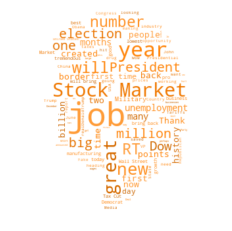

In [22]:
print(df_bloom['sentiment'].describe())

# wordcloud for df

text = " ".join(tweet for tweet in df_bloom['text'][df_bloom['text'].str.contains(r'^(?:(?!https|co|amp).)*$')])

# Create and generate a word cloud image:
wordcloud = WordCloud(max_font_size=50, max_words=100, background_color="white",mask=trump_mask_T, 
                      contour_color ='black',color_func=custom_color).generate(text)

# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

wordcloud.to_file("wordcloud_bloom.png") # save file

In [132]:
#print(df_bloom['sentiment'].describe(), df['vader'].describe())
column_id = ['count', 'mean', 'std', 'min', '25%', '50%', '75%' ,'max']
bloom_desc = list(round(df_bloom['sentiment'].describe(), 2))
All_desc = list(round(df['vader'].describe(),2))
tabledict = {'All tweets': All_desc, 'Selected tweets': bloom_desc}
tableX =  pd.DataFrame(tabledict, index = column_id).T
display(tableX)
display(tableX.to_latex(index=False))

,count,mean,std,min,25%,50%,75%,max
All tweets,19622.0,0.22,0.55,-0.99,-0.1,0.36,0.70,0.99
Selected tweets,383.0,0.32,0.54,-0.97,0.0,0.53,0.79,0.98


'\\begin{tabular}{rrrrrrrr}\n\\toprule\n   count &  mean &   std &   min &  25\\% &   50\\% &   75\\% &   max \\\\\n\\midrule\n 19622.0 &  0.22 &  0.55 & -0.99 & -0.1 &  0.36 &  0.70 &  0.99 \\\\\n   383.0 &  0.32 &  0.54 & -0.97 &  0.0 &  0.53 &  0.79 &  0.98 \\\\\n\\bottomrule\n\\end{tabular}\n'

In [48]:
# df_bloom = df_bloom.reset_index(drop=True)
# df = df.reset_index(drop=True).sort_values(by=['datetime']) # set index to date
date = [i[0]+'-'+i[1][:8] for i in df_bloom['timestamp'].str.split('T')] # slice date
df_bloom['datetime'] = date
df_bloom['datetime'] = pd.to_datetime(df_bloom['datetime'], format='%Y-%m-%d-%H:%M:%S') # format datetime 
df_bloom['datetime']
df_bloom.index = df_bloom['datetime']

In [108]:
df_bloom_Y = df_bloom['sentiment'].groupby(pd.Grouper(freq='Y'))
display(round(df_bloom_Y.describe(),2))
df_Y = df['vader'].groupby(pd.Grouper(freq='Y'))
display(round(df_Y.describe(),2))



,count,mean,std,min,25%,50%,75%,max
datetime,,,,,,,,
2017-12-31,125.0,0.31,0.49,-0.97,0.00,0.43,0.73,0.94
2018-12-31,108.0,0.36,0.53,-0.90,0.00,0.54,0.81,0.98
2019-12-31,150.0,0.30,0.59,-0.97,-0.14,0.54,0.79,0.96


,count,mean,std,min,25%,50%,75%,max
datetime,,,,,,,,
2015-12-31,7536.0,0.26,0.48,-0.97,0.00,0.36,0.67,0.98
2016-12-31,4037.0,0.17,0.54,-0.96,-0.26,0.34,0.62,0.97
2017-12-31,2292.0,0.20,0.58,-0.97,-0.25,0.36,0.72,0.98
2018-12-31,3049.0,0.23,0.63,-0.99,-0.34,0.42,0.80,0.99
2019-12-31,2708.0,0.16,0.63,-0.98,-0.44,0.29,0.74,0.98


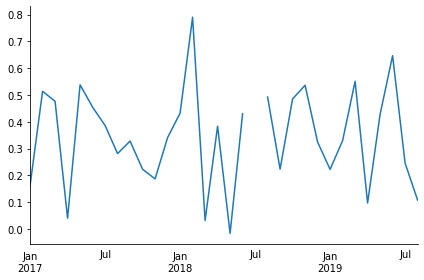

In [95]:
df_bloom['sentiment'].resample('M').mean().plot()
#df['vader'].resample('d').mean().plot()
ax = plt.gca()
ax.xaxis.label.set_visible(False) # remove axis label
ax.spines['right'].set_visible(False) # remove right spine
ax.spines['top'].set_visible(False) # remove top spine
ax.xaxis.set_ticks_position('none') # remove ticks from axis
plt.tight_layout() # prevents cutting off labels      
plt.savefig('SentimentsBloom.png')
plt.show()

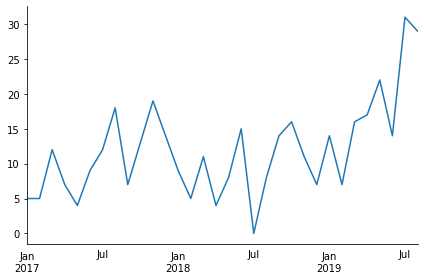

In [85]:
df_bloom['sentiment'].resample('M').count().plot() #secondary_y=True,label='Count',legend=True
#df_bloom['sentiment'].resample('M').mean().plot(label='Sentiment', legend=True)
# df['vader'].resample('M').count().plot(label='All tweets', legend=True)
ax = plt.gca()
ax.xaxis.label.set_visible(False) # remove axis label
ax.spines['right'].set_visible(False) # remove right spine
ax.spines['top'].set_visible(False) # remove top spine
ax.xaxis.set_ticks_position('none') # remove ticks from axis
plt.tight_layout() # prevents cutting off labels      
plt.savefig('CounterSentiments.png')
plt.show()

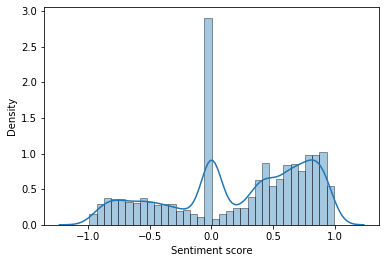

In [129]:
df_drop_datetime =df.drop("datetime", axis=1)
df_sentiment_mean_by_day = df_drop_datetime.groupby('datetime')['vader'].mean()
Sentplot = sns.distplot(df_sentiment_mean_by_day, hist=True, kde=True,
             hist_kws={'edgecolor':'black'})


Sentplot.set_xlabel('Sentiment score')
Sentplot.set_ylabel('Density')
Sentplot.xaxis.label.set_fontsize(10)
Sentplot.yaxis.label.set_fontsize(10)
FigKDE = Sentplot.get_figure()
FigKDE.savefig('KDEPLOT.png')

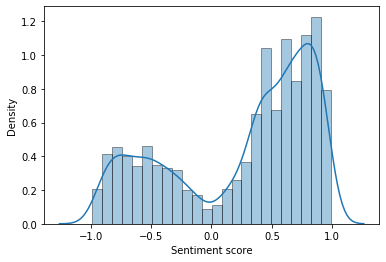

In [131]:
df_drop_null = df_drop_datetime.query('vader!=0')
df_null_sentiment_mean_by_day = df_drop_null.groupby('datetime')['vader'].mean()
Sentplot = sns.distplot(df_null_sentiment_mean_by_day, hist=True, kde=True,
             hist_kws={'edgecolor':'black'})


Sentplot.set_xlabel('Sentiment score')
Sentplot.set_ylabel('Density')
Sentplot.xaxis.label.set_fontsize(10)
Sentplot.yaxis.label.set_fontsize(10)
FigKDE = Sentplot.get_figure()
FigKDE.savefig('KDEPLOT2.png')

In [136]:
df_bloom_drop_datetime =df_bloom.drop("datetime", axis=1)
df_bloom_drop_datetime

,dow,id,id_int,text,timestamp,sentiment
datetime,,,,,,
2019-08-23 19:01:20,25686.6699,1164975929598316544,1164975929598316500,The Dow is down 573 points perhaps on the news...,2019-08-23T19:01:20.000Z,0.0000
2019-08-23 14:59:05,25898.0508,1164914963766546435,1164914963766546400,....all deliveries of Fentanyl from China (or ...,2019-08-23T14:59:05.000Z,-0.5972
2019-08-23 11:24:51,25898.0508,1164861052611420160,1164861052611420200,"The Economy is strong and good, whereas the re...",2019-08-23T11:24:51.000Z,0.9080
2019-08-23 03:49:50,26148.7305,1164746544677101568,1164746544677101600,RT @Jim_Jordan: Business owners and hard-worki...,2019-08-23T03:49:50.000Z,0.3716
2019-08-23 03:43:23,25898.0508,1164744918302175233,1164744918302175200,RT @VP: Under the #USMCA Utah will have more j...,2019-08-23T03:43:23.000Z,0.5198
2019-08-23 03:26:23,25898.0508,1164740642926419968,1164740642926420000,RT @MariaBartiromo: The economy is poised to c...,2019-08-23T03:26:23.000Z,0.5106
2019-08-22 14:21:52,26252.2402,1164543211660042241,1164543211660042200,The Economy is doing really well. The Federal ...,2019-08-22T14:21:52.000Z,0.9542
2019-08-21 21:42:23,26202.7305,1164291681685872640,1164291681685872600,"“Tax cuts, deregulation, and an Administration...",2019-08-21T21:42:23.000Z,-0.1027
2019-08-21 12:32:37,26202.7305,1164153329196384256,1164153329196384300,The Fake News LameStream Media is doing everyt...,2019-08-21T12:32:37.000Z,-0.0752


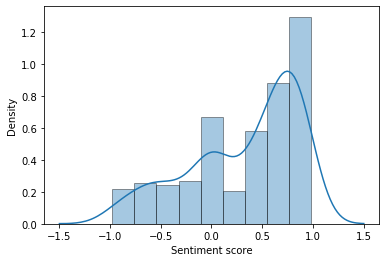

In [138]:
bloom_sentiment_mean_by_day = df_bloom_drop_datetime.groupby('datetime')['sentiment'].mean()
Sentplot = sns.distplot(bloom_sentiment_mean_by_day, hist=True, kde=True,
             hist_kws={'edgecolor':'black'})


Sentplot.set_xlabel('Sentiment score')
Sentplot.set_ylabel('Density')
Sentplot.xaxis.label.set_fontsize(10)
Sentplot.yaxis.label.set_fontsize(10)
FigKDE = Sentplot.get_figure()
FigKDE.savefig('KDEPLOT.png')

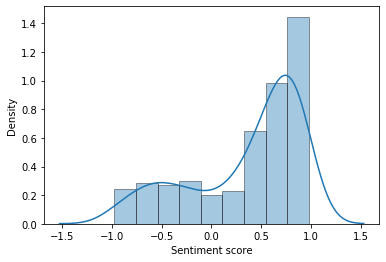

In [140]:
df_bloom_drop_null = df_bloom_drop_datetime.query('sentiment!=0')
bloom_null_sentiment_mean_by_day = df_bloom_drop_null.groupby('datetime')['sentiment'].mean()
Sentplot = sns.distplot(bloom_null_sentiment_mean_by_day, hist=True, kde=True,
             hist_kws={'edgecolor':'black'})


Sentplot.set_xlabel('Sentiment score')
Sentplot.set_ylabel('Density')
Sentplot.xaxis.label.set_fontsize(10)
Sentplot.yaxis.label.set_fontsize(10)
FigKDE = Sentplot.get_figure()
FigKDE.savefig('KDEPLOT2.png')